Causal analysis with PyMC: Answering "What If?" with the new do operator
[ref](https://github.com/pymc-labs/research/blob/main/blog-posts/do_operator/do_operator_blogpost.ipynb)

In [1]:
import arviz as az
# poetry add daft-pgm
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor as pt
import seaborn as sns
from packaging import version

In [4]:
# check we have the required versions
assert version.parse(pm.__version__) >= version.parse("5.8.0")
version.parse(pm.__version__)

<Version('5.20.1')>

In [3]:
# import the new functionality
from pymc import do, observe

In [5]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = [10, 6]
SEED = 42
sns.set_theme(context="notebook", style="white")

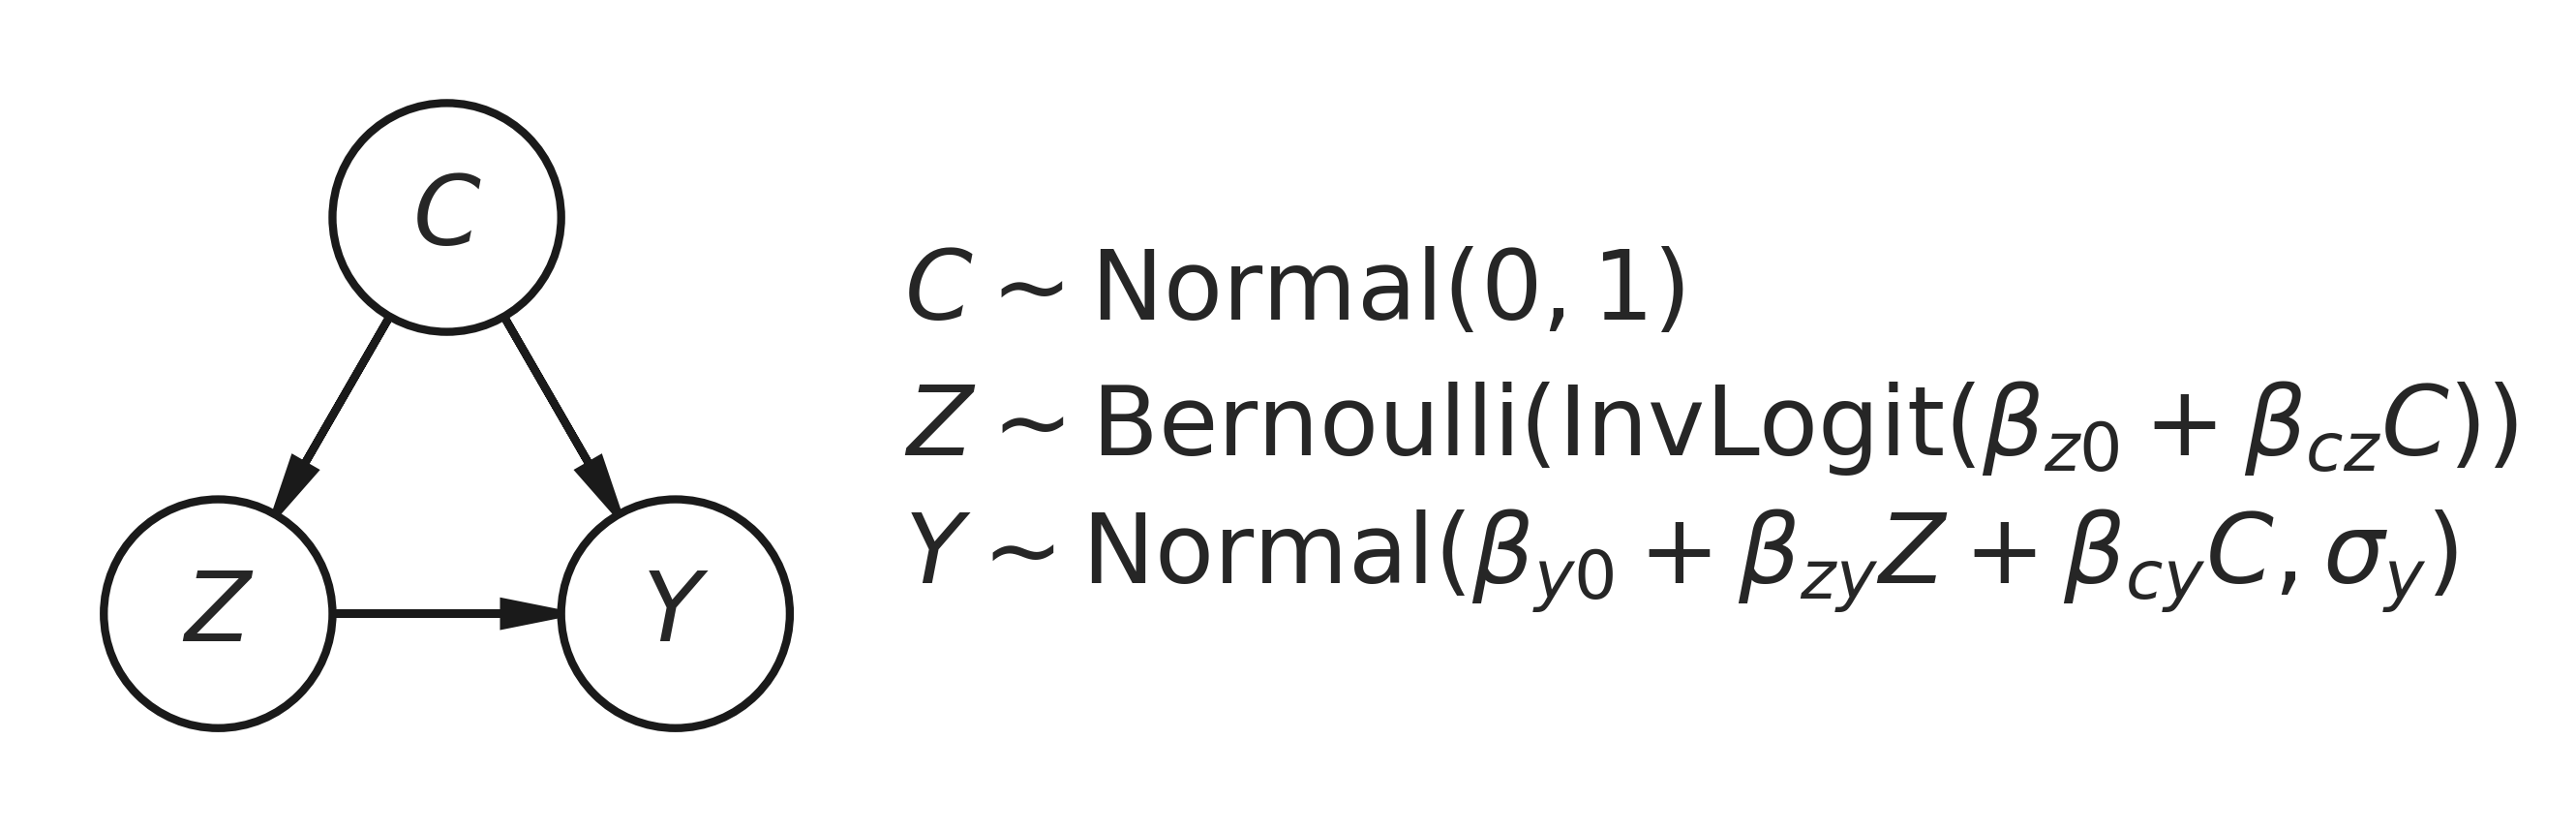

In [6]:
pgm = daft.PGM()
pgm.add_node("y", "$Y$", 0, 0)
pgm.add_node("z", "$Z$", -1, 0)
pgm.add_node("c", "$C$", -0.5, 0.866)
pgm.add_edge("z", "y")
pgm.add_edge("c", "y")
pgm.add_edge("c", "z")
pgm.add_text(0.5, 0.6, r"$C \sim \mathrm{Normal}(0, 1)$")
pgm.add_text(
    0.5, 0.3,
    r"$Z \sim \mathrm{Bernoulli}(\operatorname{InvLogit}(\beta_{z0} + \beta_{cz} C))$",
)
pgm.add_text(
    0.5, 0,
    r"$Y \sim \mathrm{Normal}(\beta_{y0} + \beta_{zy} Z + \beta_{cy} C, \sigma_y)$",
)
pgm.render(dpi=300);

we have a binary treatment variable $Z$ (ads on/off) which may or may not causally influence an outcome (sales). However, this relationship suffers from confounding by $C$
 (TV) which causally influences both treatment and outcome. Further, we turn this into a Bayesian causal DAG by specifying probabilistic causal relationships between the nodes. A prior is placed on 
  $C$ as it has no parent nodes. <br>
 Basically, two regressions are setting up: a logistic regression $Z $ and a liner regression $Y = $

/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/pymc/model/core.py:461: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/pymc/model/core.py:946: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(


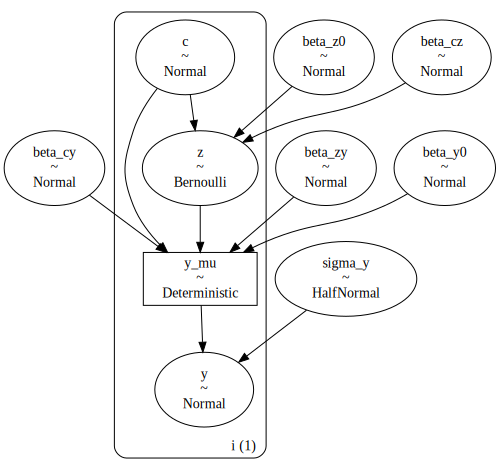

In [20]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- C -> Z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on Z -> Y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    z = pm.Bernoulli("z", p=pm.invlogit(beta_z0 + beta_cz * c), dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")

pm.model_to_graphviz(model_generative)

In [21]:

true_ATE = 0.0

true_values = {
    "beta_z0": 0.0,
    "beta_y0": 0.0,
    "beta_cz": 1.5,
    "beta_zy": true_ATE,
    "beta_cy": 1.0,
    "sigma_y": 0.2,
}

model_simulate = do(model_generative, true_values)

In [22]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=SEED)

observed = {
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["y"].values.flatten(),
    "z": simulate.prior["z"].values.flatten(),
}

df = pd.DataFrame(observed).sort_values("c", ascending=False)

Sampling: [c, y, z]


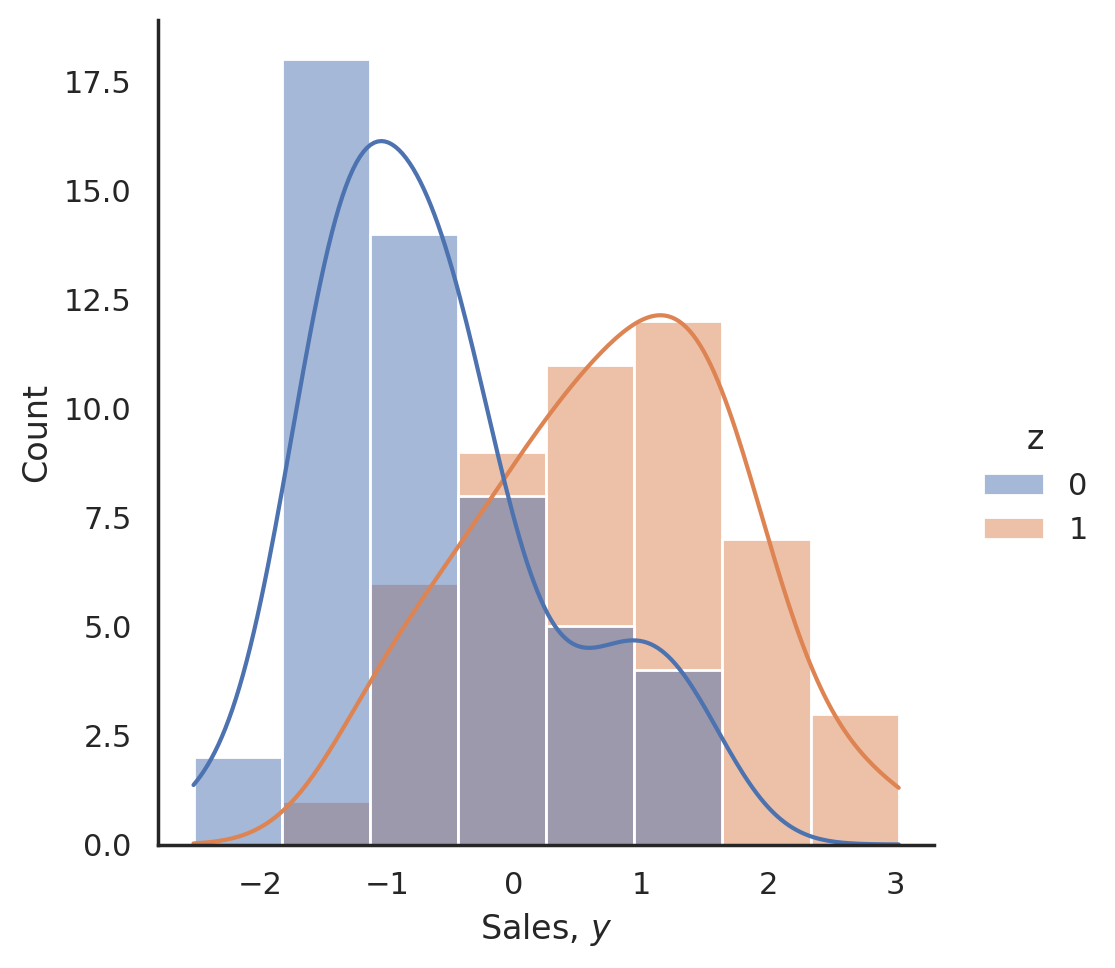

In [23]:
ax = sns.displot(data=df, x="y", hue="z", kde=True)
ax.set(xlabel="Sales, $y$");

In [24]:
model_inference = observe(model_generative, {"c": df["c"], "y": df["y"], "z": df["z"]})
model_inference.set_dim("i", N, coord_values=np.arange(N))

In [25]:
with model_inference:
    idata = pm.sample(random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_y0, beta_cy, beta_cz, beta_z0, beta_zy, sigma_y]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


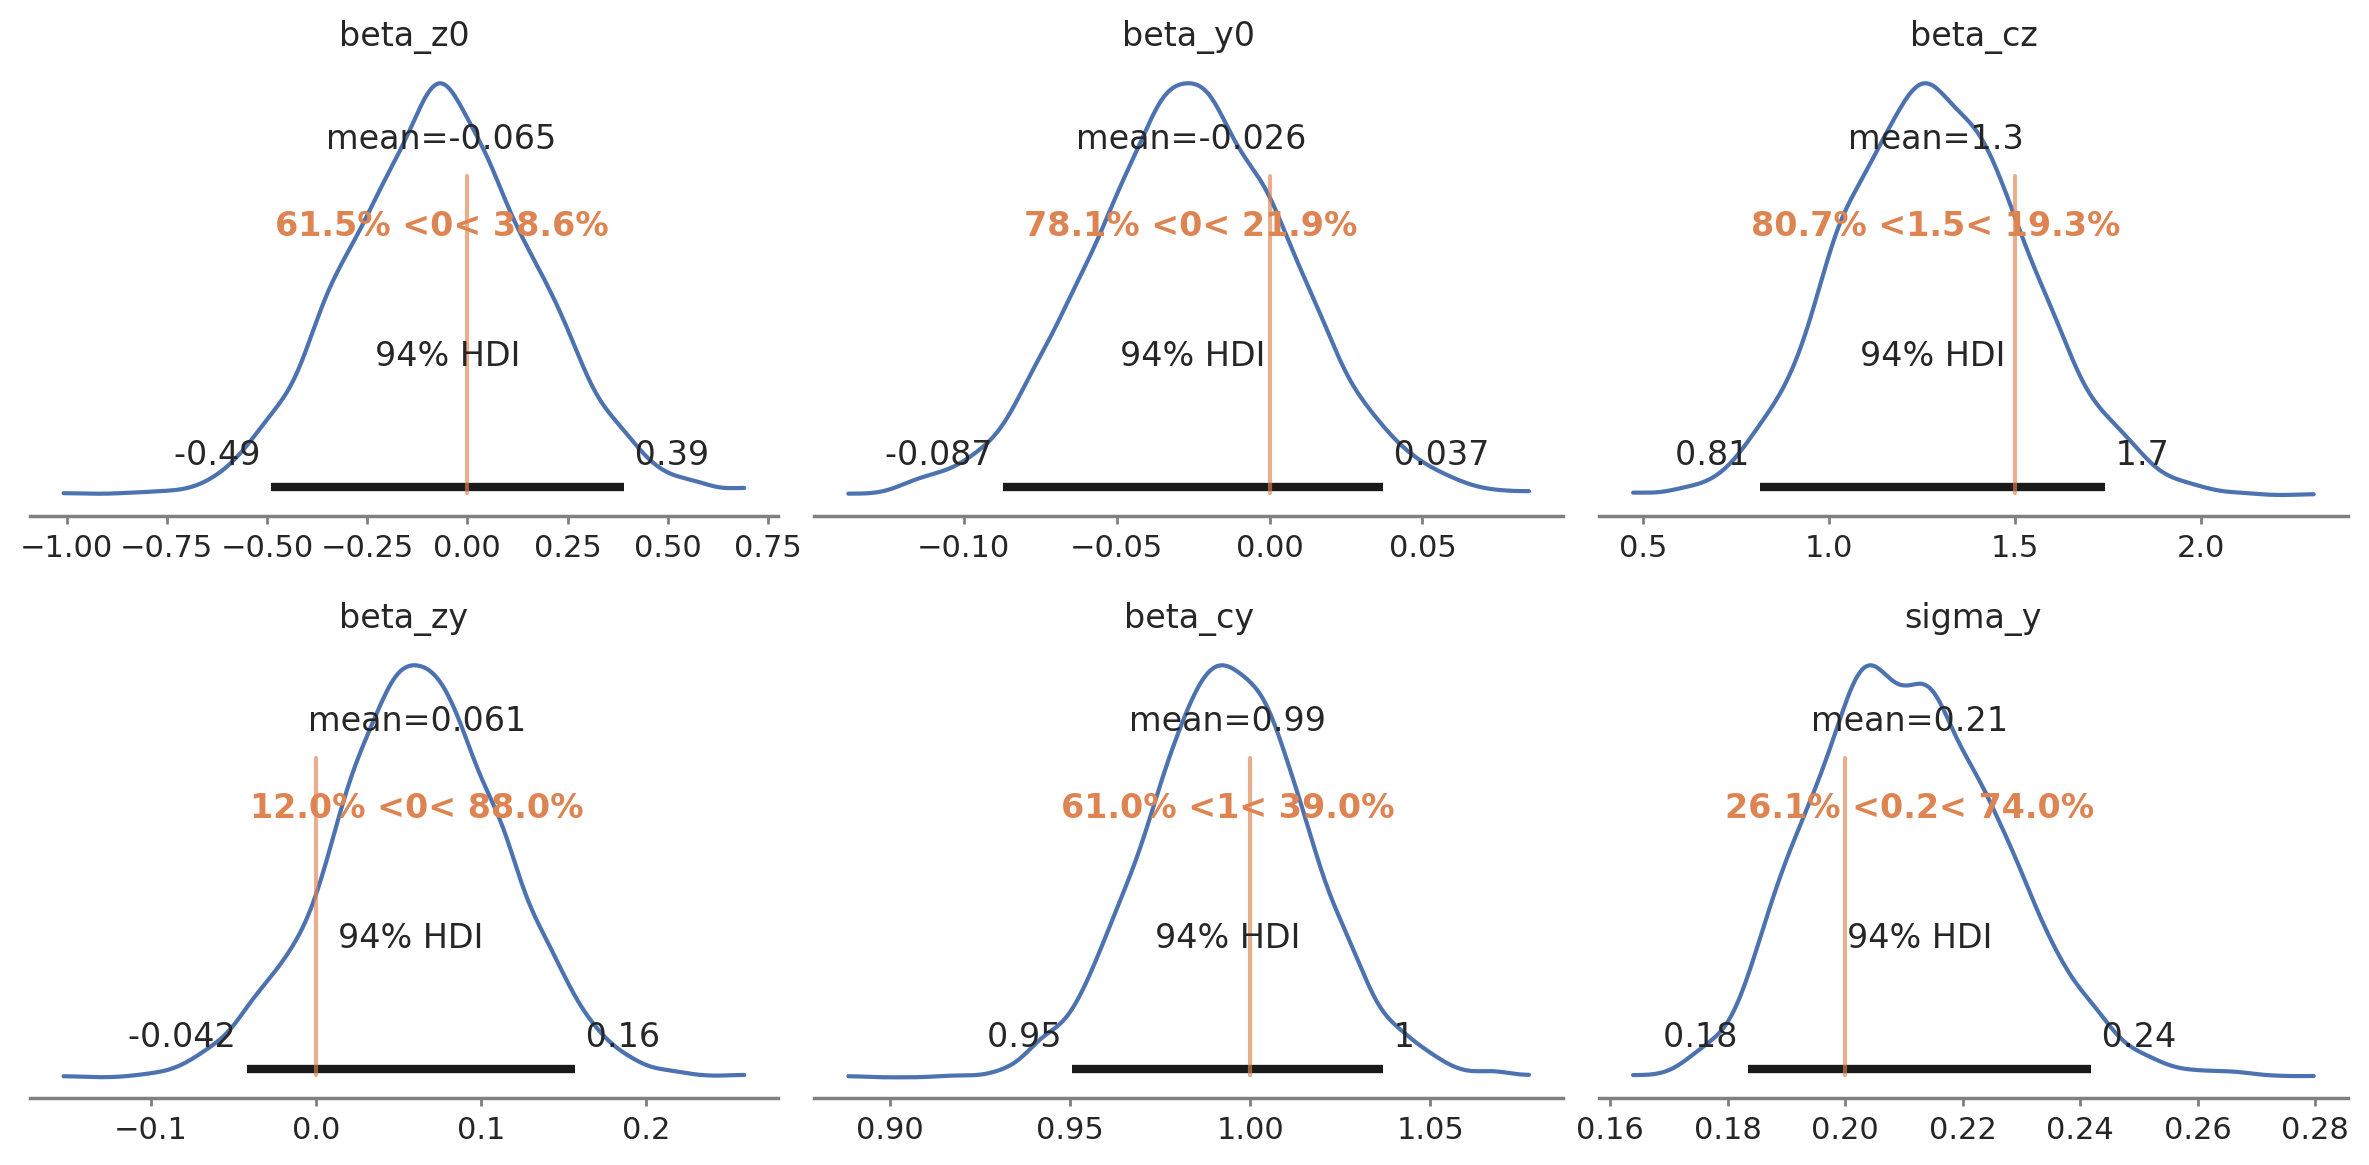

In [26]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 6),
)
plt.tight_layout();

In [27]:
# Replace c with its observed values
model_counterfactual = do(model_inference, {"c": df["c"]})

In [28]:
# Replace c with its observed values
model_counterfactual = do(model_inference, {"c": df["c"]})

In [31]:

# Generate models with Z=0 and Z=1
model_z0 = do(model_counterfactual, {"z": np.zeros(N, dtype="int32")}, prune_vars=True)
model_z1 = do(model_counterfactual, {"z": np.ones(N, dtype="int32")}, prune_vars=True)

In [32]:
# Sample new sales data assuming Google Ads off: P(Y | c, do(z=0))
idata_z0 = pm.sample_posterior_predictive(
    idata,
    model=model_z0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)
# Sample new sales data assuming Google Ads on: P(Y | c, do(z=1))
idata_z1 = pm.sample_posterior_predictive(
    idata,
    model=model_z1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)

Sampling: []


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: []


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [33]:
# calculate estimated ATE
ATE_est = idata_z1.predictions - idata_z0.predictions
print(f"Estimated ATE = {ATE_est.y_mu.mean().values:.2f}")

Estimated ATE = 0.06


In [34]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)

    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")

    # right plot of estimated ATE
    az.plot_posterior(
        idata, var_names="beta_zy", ref_val=true_ATE, round_to=4, ax=ax[1]
    )

    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    ax[1].set(title="Average Treatment Effect")
    plt.tight_layout()

    plt.suptitle(
        "Unit level estimates with do operation,\nand estimate of Average Treatment Effect",
        y=1.05,
    );

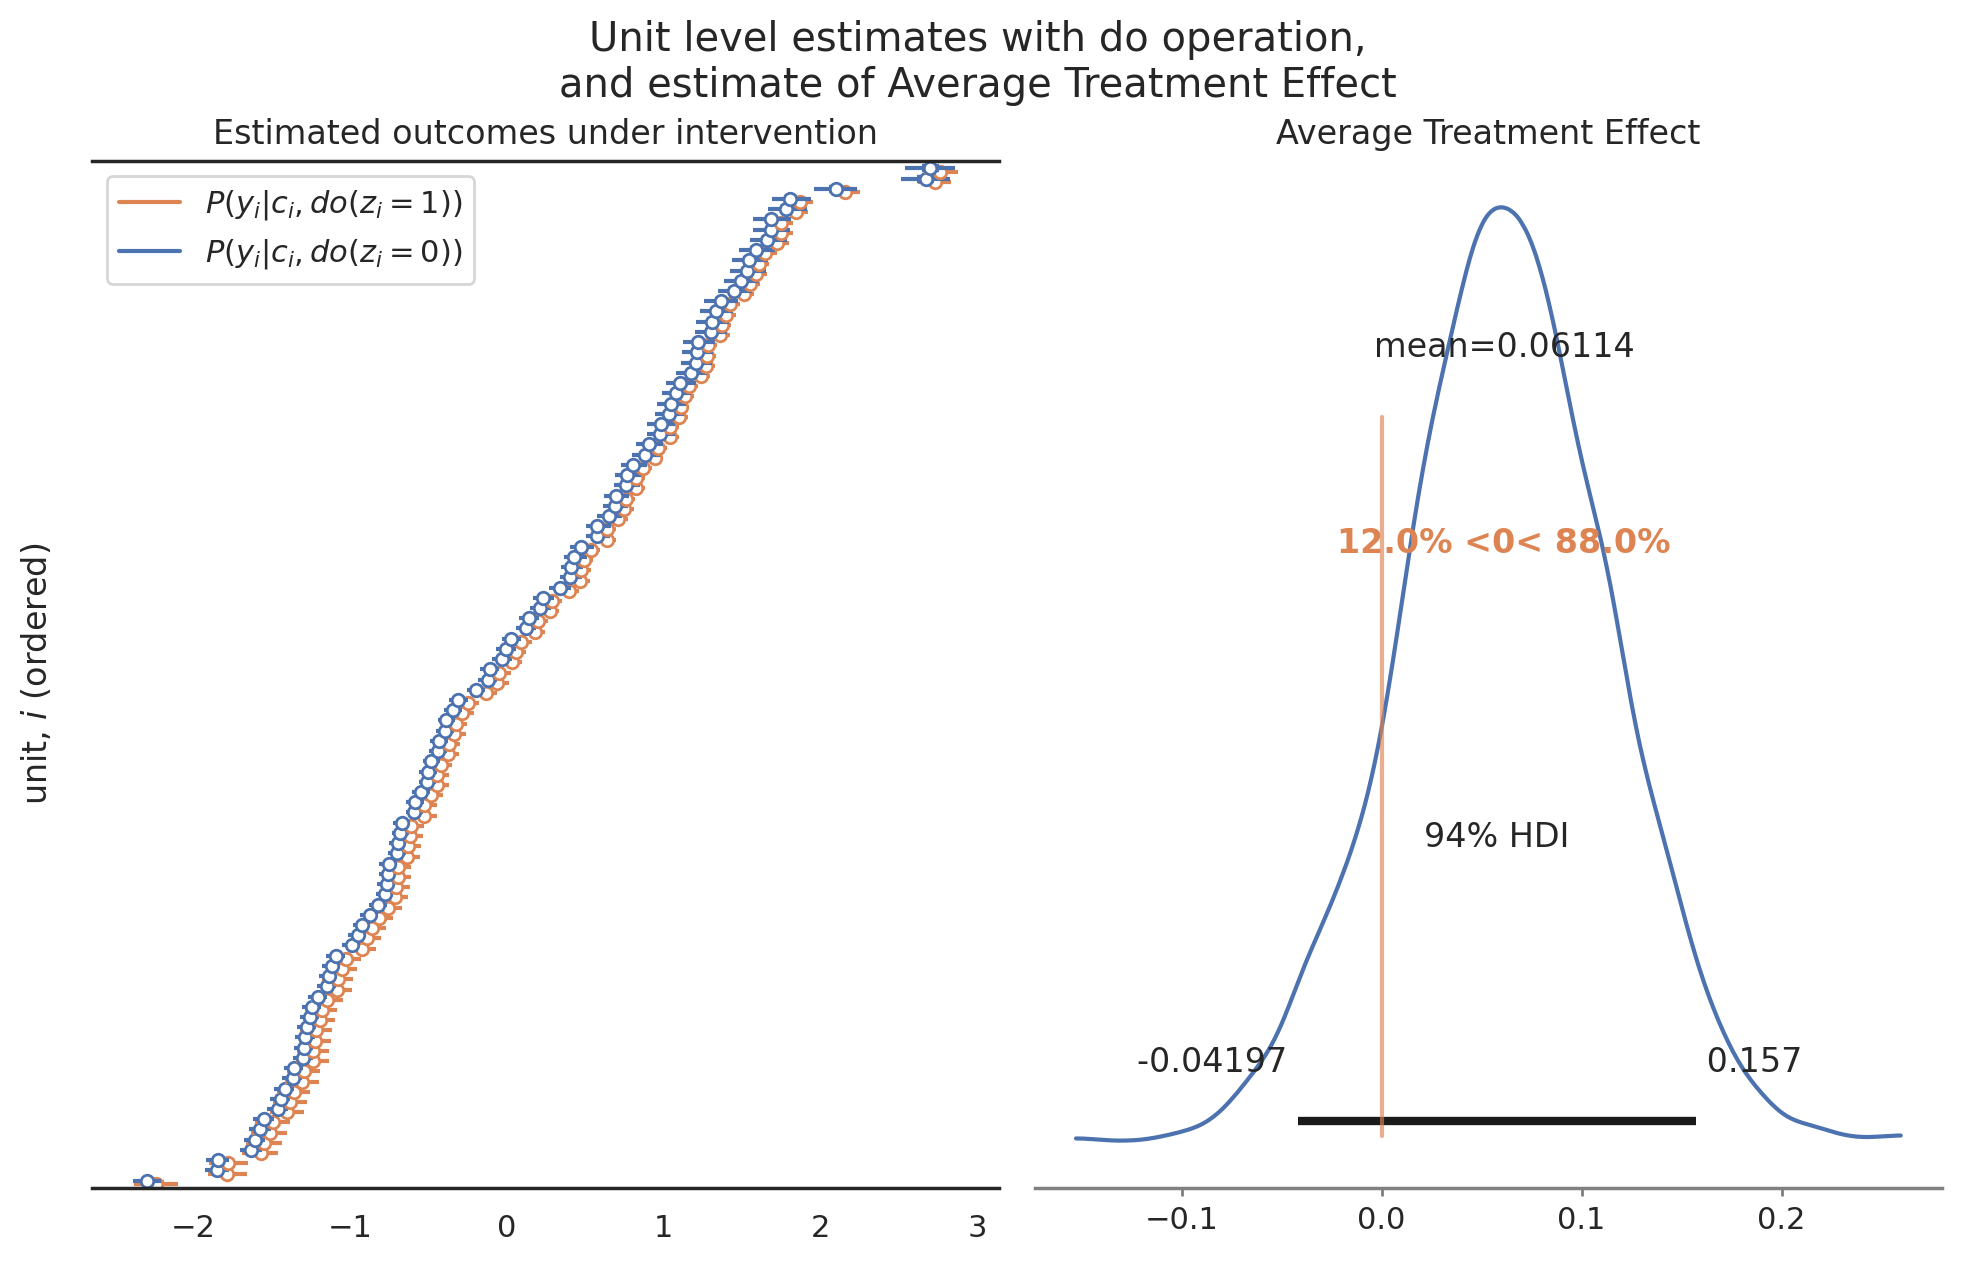

In [35]:
plot_causal_estimates(
    [idata_z0, idata_z1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)

In [36]:
percent = (idata.posterior["beta_zy"] / idata.posterior["beta_cy"]) * 100
print(
    f"Causal effect of Google Ads on sales is {percent.mean():.1f}% [{az.hdi(percent).x.data[0]:.1f}%,{az.hdi(percent).x.data[1]:.1f}%] of the effect of TV on sales"
)

Causal effect of Google Ads on sales is 6.2% [-4.0%,16.4%] of the effect of TV on sales
